In [1]:
import os ; import sys ; sys.path.append('../dependencies/') ; import pandas as pd ; import numpy as np ; import matplotlib.pyplot as plt
import shutil ; import flopy ; from flopy.utils.gridgen import Gridgen  ; from flopy.utils.gridintersect import GridIntersect
import shapefile as sf ; from shapely.geometry import Polygon, LineString, MultiLineString, Point # print(f'Flopy version:{flopy.__version__}')
from pathlib import Path ; sim_ws =  Path("./03_out") ; sim_ws.mkdir(exist_ok=True)   ; sim_ws0 =  Path("./02_out")
ref_data3 = os.path.join('02_out') ; ref_data4  ='E:\\15_REPOS\\00_data_intern\\Syymple\\sgn'

In [15]:
%%capture
sim = flopy.mf6.MFSimulation.load(sim_ws=ref_data3) ; sim.set_sim_path(sim_ws) ; sim.write_simulation(); sim.set_sim_path(sim_ws) ; sim.write_simulation()

In [3]:
gwf = sim.get_model("sgn")  ; ix = GridIntersect(gwf.modelgrid)
barrier_xy = Point(1519614., 5031870.)  ; print(barrier_xy)  ; rate = -30/1000 #30 l/s to m3/s
barrier_cell = ix.intersect(barrier_xy).cellids

POINT (1519614 5031870)


In [4]:
gwf.wel.stress_period_data

{internal}
(     cellid_layer  cellid_cell       q   boundname
0               0         4736  0.0000  well-p1_ln
1               0         4735  0.0000  well-p2_ln
2               0         4742  0.0000  well-p3_ln
3               0         4739  0.0000  well-p4_ln
4               0         5138  0.0000  well-p5_ln
..            ...          ...     ...         ...
138             0         7584 -0.0095  well-19/16
139             0         7039 -0.0095  well-19/18
140             0         7590 -0.0095  well-19/19
141             0         7057 -0.0095  well-19/20
142             0         5637 -0.0095  well-19/21

[143 rows x 4 columns])

In [5]:
for i in barrier_cell:
    gwf.wel.stress_period_data.append_data([((0, i), rate, 'hydraulic_barrier')])

In [6]:
gwf.wel.stress_period_data

{internal}
(     cellid_layer  cellid_cell       q          boundname
0               0         4736  0.0000         well-p1_ln
1               0         4735  0.0000         well-p2_ln
2               0         4742  0.0000         well-p3_ln
3               0         4739  0.0000         well-p4_ln
4               0         5138  0.0000         well-p5_ln
..            ...          ...     ...                ...
139             0         7039 -0.0095         well-19/18
140             0         7590 -0.0095         well-19/19
141             0         7057 -0.0095         well-19/20
142             0         5637 -0.0095         well-19/21
0               0         9468 -0.0300  hydraulic_barrier

[144 rows x 4 columns])

In [7]:
sim.write_simulation(silent=True)

In [8]:
sim.run_simulation(silent=False)

FloPy is using the following executable to run the model: C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Scripts\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/10/2025

   MODFLOW 6 compiled Feb 14 2025 13:40:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither 

(True, [])

In [9]:
fname = os.path.join(sim_ws, gwf.name + '.hds') ; hdobj = flopy.utils.HeadFile(fname, model=gwf)  ; head = hdobj.get_alldata()
hmin = head.min() ; hmax = head.max()    ;  print(f'Max head in model run: {hmax}')               ; print(f'Min head in model run: {hmin}') ; head.shape
hdtimes = hdobj.get_times()              ; fname2 = os.path.join(sim_ws0, gwf.name + '.hds')      ; hist_hdobj = flopy.utils.HeadFile(fname2, model=gwf)

Max head in model run: 103.0247763498709
Min head in model run: 97.08266024432784


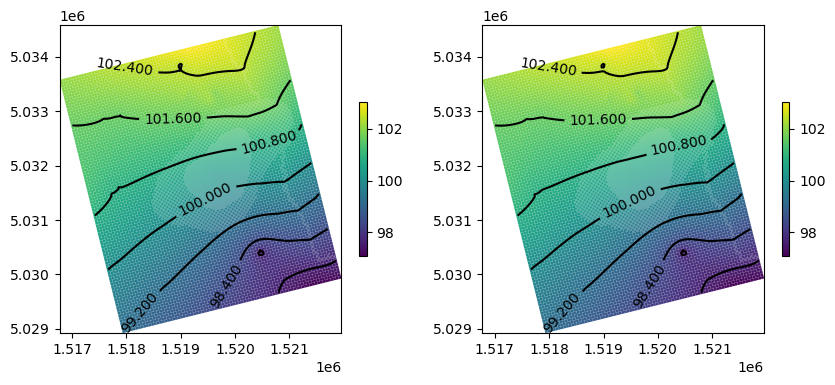

In [10]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
hdobj.plot      (ax0, mflay=0, totim=hdtimes[0] ,colorbar=True, contour=True, clabel=True)    
hist_hdobj.plot (ax1, mflay=0, totim=hdtimes[0] ,colorbar=True, contour=True, clabel=True)
plt.show() 

In [11]:
hdobj.get_kstpkper() 
deltah = hdobj.get_data(mflay=0, kstpkper=(3,0)) - hist_hdobj.get_data(mflay=0,  kstpkper=(3,0)) #; print(deltah)

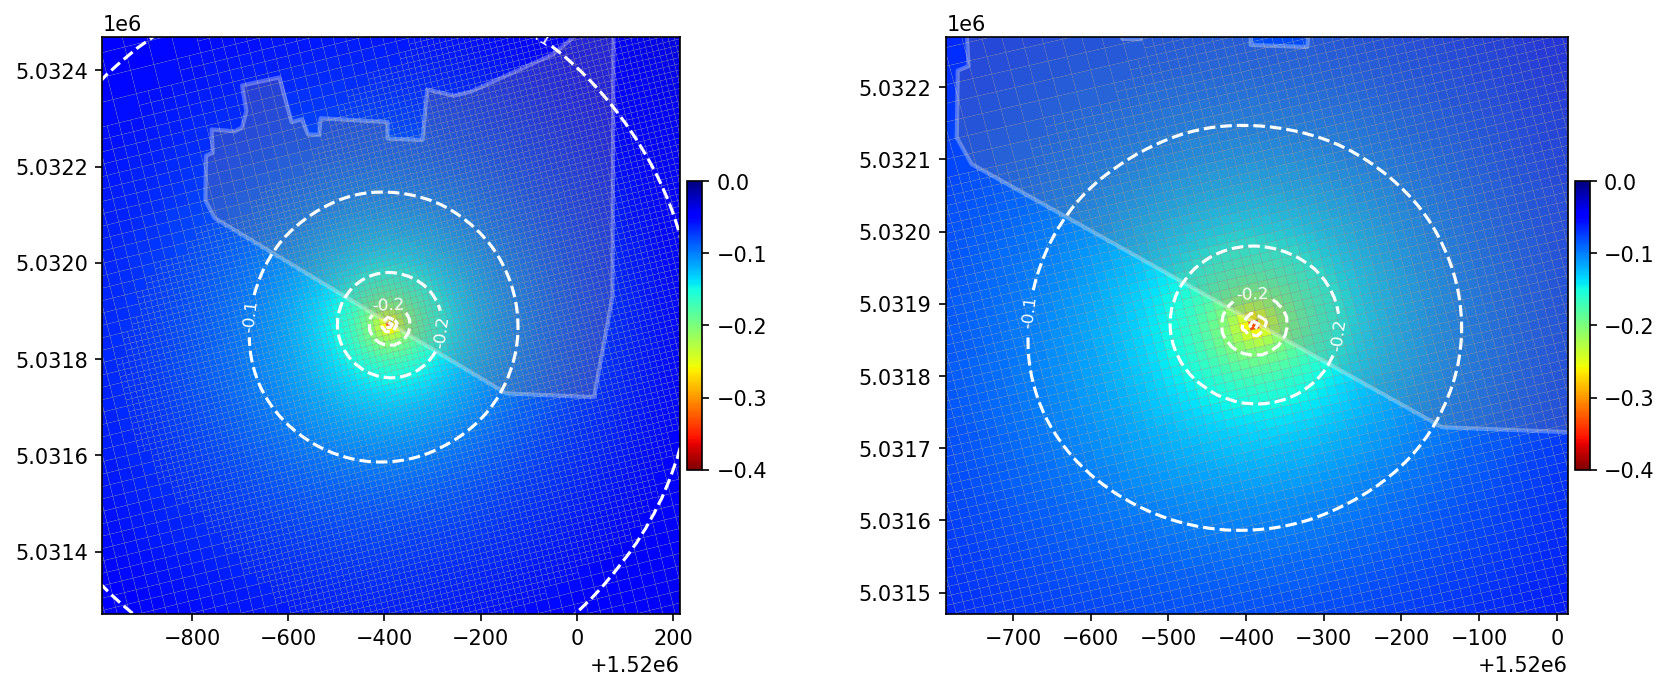

In [12]:
fig = plt.figure(figsize=(14, 5), dpi=150)  
ax = fig.add_subplot(121, aspect='equal')

ext_offset = 600 ; extent=(1519614-ext_offset, 1519614+ext_offset, 5031870-ext_offset, 5031870+ext_offset) #; extent = gwf.modelgrid.extent 
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0, extent=extent) 
dh = mm.plot_array(edgecolor='grey', a=deltah[0], cmap='jet_r', alpha=1, linewidth=0.1, vmin=-0.4, vmax=0)
cb = plt.colorbar(dh, shrink=0.5, pad=0.01)
levels = np.arange(-0.4, 0., 0.05)
cs = mm.contour_array(deltah[0], colors='white', levels=levels)
plt.clabel(cs, fmt='%.1f', colors='white', fontsize=8)
flopy.plot.plot_shapefile(sf.Reader(os.path.join(ref_data4, 'shp','Site_area.shp')), linewidth=2, facecolor='grey', edgecolor='w', alpha=0.3);

ax = fig.add_subplot(122) 
ext_offset = 400 ; extent=(1519614-ext_offset, 1519614+ext_offset, 5031870-ext_offset, 5031870+ext_offset) 
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0, extent=extent) 
dh = mm.plot_array(edgecolor='grey', a=deltah[0], cmap='jet_r', alpha=1, linewidth=0.1, vmin=-0.4, vmax=0)
cb = plt.colorbar(dh, shrink=0.5, pad=0.01)
levels = np.arange(-0.4, 0., 0.05)
cs = mm.contour_array(deltah[0], colors='white', levels=levels)
plt.clabel(cs, fmt='%.1f', colors='white', fontsize=8)
flopy.plot.plot_shapefile(sf.Reader(os.path.join(ref_data4, 'shp','Site_area.shp')), linewidth=2, facecolor='grey', edgecolor='w', alpha=0.3);
plt.show()

In [13]:
fname_mf6 = os.path.join(sim_ws, list(sim.model_names)[1] + ".ucn") ; ucnobj_mf6 = flopy.utils.HeadFile(fname_mf6, precision="double", text="CONCENTRATION")
fname_mf6 = os.path.join(sim_ws0, list(sim.model_names)[1] + ".ucn") ; hist_ucnobj_mf6 = flopy.utils.HeadFile(fname_mf6, precision="double", text="CONCENTRATION")
deltac = ucnobj_mf6.get_data(mflay=0, kstpkper=(3,0)) - hist_ucnobj_mf6.get_data(mflay=0,  kstpkper=(3,0))

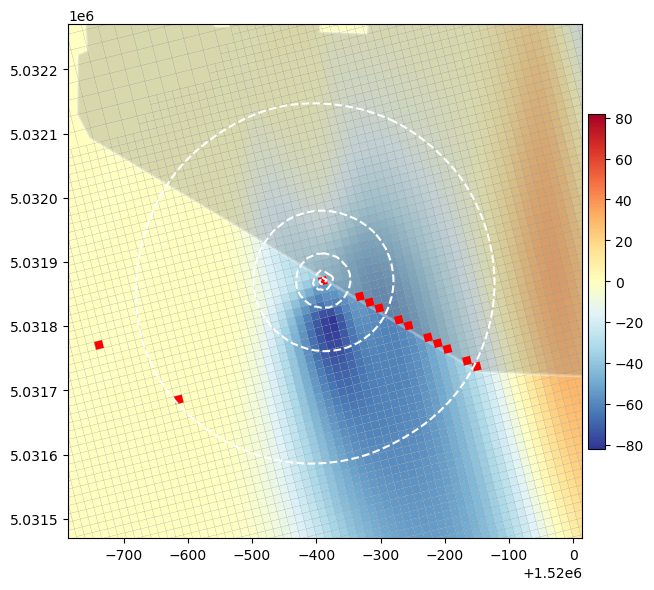

In [14]:
fig = plt.figure(figsize=(7, 7), tight_layout=True)
ax = fig.add_subplot(111, aspect='equal') ; #extent=(1519100, 1520300, 5031600, 5032600) 
ext_offset = 400 ; extent=(1519614-ext_offset, 1519614+ext_offset, 5031870-ext_offset, 5031870+ext_offset) 
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0, extent=extent) ; a = deltac[0].copy() ; vmax = abs(a).max() ; vmin = -vmax
dc = mm.plot_array(edgecolor='grey', a=a, cmap='RdYlBu_r', alpha=1, linewidth=0.1, vmin=vmin, vmax=vmax)
cb = plt.colorbar(dc, shrink=0.5, pad=0.01)
levels = np.arange(-0.4, 0., 0.05)
cs = mm.contour_array(deltah[0], colors='white', levels=levels)

flopy.plot.plot_shapefile(sf.Reader(os.path.join(ref_data4, 'shp','Site_area.shp')), linewidth=2, facecolor='grey', edgecolor='w', alpha=0.3);
wells = mm.plot_bc("WEL")